In [ ]:
""" 
Summary plots, using old task representations. 
Motivated by Luca experiment (Kedar)
"""

"""
Hi Kedar,
I've confirmed that drawmonkey.analysis.dataset works for Luca (to extract datasets)
And I've written a quick tutorial for classifying Luca's tasks, which you can then use
to make seprate plots (drawings and behavior scores) for each of these task categories:
"""



"""
Hi Kedar,
I was thinking it would be useful to make across-day plots to track learning/progression.

Luca:
for each stage (e.g., 4-5), plot all beh trials and score.

This could work using the Dataset class (which requires first during
drawmonkey.analysis.dataset to extract the .pkl file) or using Probedat."""
"""

In [87]:
## my questions
# - is he better at certain directions?
# - are acute angles easy or hard?
# - are obtuse angles easy or hard?
# - are shorter or longer Vs harder? (might covary with angle)
# - what 'grid positions' is he best at? worst at?
# - *is training helping? metric to use?
# - *how does his behavior compare across days?

In [88]:
## NAIVE8LUCA6 ##
# - for each angle (23..67) two blocks: pointing up-down, and the rest.
# - goal: train him to do better on up-down blocks, compared to before.

In [89]:
%load_ext autoreload
%autoreload 2

# change to pythonlib for installation & import
#import sys
#sys.path.append('.')
#sys.path.append('~/Desktop/rockefeller/pythonlib')
#import os
#os.chdir('/Users/kdu/Desktop/rockefeller/pythonlib')

# install miscellaneous
#%pip install imageio
#%pip install pythonlib
#%pip install pickle5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
# %cd ..
# from tools.utils import * 
# from tools.plots import *
# from tools.analy import *
# from tools.calc import *
# from tools.analyplot import *
# from tools.preprocess import *
# from tools.dayanalysis import *

from pythonlib.drawmodel.analysis import *
from pythonlib.tools.stroketools import *
import pythonlib
from pythonlib.tools.vectools import transform_data_to_negative_start
from pythonlib.dataset.dataset import Dataset
from pythonlib.behavior.strokeclass import StrokeClass
from pythonlib.tools.vectools import angle_diff, get_vector_between_points, get_angle, bin_angle_by_direction, transform_data_to_negative_start
import pandas as pd
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from math import pi

#from importlib import reload  
#reload(pythonlib)

##### Try loading a single dataset

In [91]:
base_dir = os.path.expanduser("~/data2")
expt = "naive8luca6" #run for chunkbyshape1, chunkbyshape2
animal = "Luca"
# rulelist = get_rulelist(animal, expt)
D = Dataset([])
# D.load_dataset_helper(animal, expt, ver="mult", rule=rulelist)
D.load_dataset_helper(animal, expt)
# D.load_tasks_helper()sub

Searching using this string:
/Users/kdu/data2/analyses/database/*Luca*naive8luca6**/*dat*.pkl
-- Splitting off dir from fname
Found this many paths:
0
Searching using this string:
/Users/kdu/data2/analyses/database/BEH/*Luca*naive8luca6**/*dat*.pkl
-- Splitting off dir from fname
Found this many paths:
1
---
/Users/kdu/data2/analyses/database/BEH/Luca-naive8luca6-null-220810_140848
----------------
Currently loading: /Users/kdu/data2/analyses/database/BEH/Luca-naive8luca6-null-220810_140848
Loaded metadat:
{'sketchpad_edges': array([[-404., -532.],
       [ 404.,  532.]]), 'metadat_probedat': {'sdate': 220705, 'edate': 220809, 'strokmodel_kind': None, 'strokmodel_tstamp': None, 'datecategories': {'220705': 1, '220706': 1, '220707': 1, '220708': 1, '220709': 1, '220710': 1, '220711': 1, '220712': 1, '220713': 1, '220714': 1, '220715': 1, '220716': 1, '220717': 1, '220718': 1, '220719': 1, '220720': 1, '220721': 1, '220722': 1, '220723': 1, '220724': 1, '220725': 1, '220726': 1, '220727'

##### Bin tasks based on task stroke features

(<Figure size 144x180 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

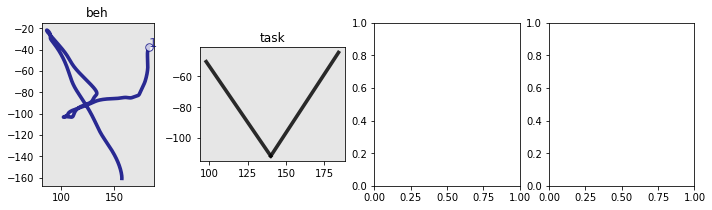

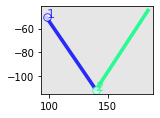

In [92]:
# Pick an example trial
indtrial = 830

# Plot it
D.plotSingleTrial(indtrial)

# Plot task using colors, to figure out what direction the task strokes are defined in.
strokes_task = D.Dat.iloc[indtrial]["strokes_task"]
D.plotMultStrokes([strokes_task])

In [93]:
# before calculating angles, find trialnumbers for lines (i.e. 1 stroke)
for ind in range(len(D.Dat)):
    Strokes = [StrokeClass(strok) for strok in D.Dat.iloc[ind]["strokes_task"]]
    list_angle = [S.extract_single_feature('angle') for S in Strokes]
    if (len(list_angle)==1):
        print(ind)

0
1
2
3
4
408
409
410
411
412
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1490
1491
1492
1493
1494
1495
1496
1630
1631
1632
1837
1838
1976
2028
2029
2030
2031
2032
2033
2034
2035
2036
2063
2064
2065
2066
2067
2068
2069
2070
2071
2085
2086
2087
2088
2089
2090
2091
2092
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129


In [94]:
## calculate [task_drawing_angle_rad, task_rotation_angle_rad, task_length] and add to D.Dat

for ind in range(len(D.Dat)):
    # Extract task strokes
    # - StrokeClass holds Nx2 numpy array: x,y data over time
    # - V-shape has 2 strokes; line has 1 stroke
    strokes_task = D.Dat.iloc[ind]["strokes_task"]
    Strokes = [StrokeClass(strok) for strok in strokes_task]
    
    # Extract three features (length, angle_between_segments (acuteness), angle_arrowhead (which way pointing)) 
    # 1) length of each stroke segment
    list_len = [S.extract_single_feature('distcum') for S in Strokes]
    len_tot = np.sum(list_len)
    #print("1. length of task: ", len_tot)
    D.Dat.loc[ind, "task_len"] = len_tot

    # before proceeding to angle calculation: check if 1-stroke task (straight line, during warmup)
    # - has no rotation/drawing angles
    if (len(Strokes)==1):
        D.Dat.loc[ind, "task_draw_angle_rad"] = 0
        D.Dat.loc[ind, "task_rot_angle_rad"] = 0
        continue
        
    
    # 2) Angle between two segments
    list_angle = [S.extract_single_feature('angle') for S in Strokes]
    # -- given each strok's angle, you can compute the angle between them
    from math import pi
    ad = pi - angle_diff(list_angle[0], list_angle[1])
    #print("2. angle between two segments (rad): ", ad)
    D.Dat.loc[ind, "task_draw_angle_rad"] = ad

    # 3) Direction the "arrowhead" is pointing
    # vector pointing in direction of arrowhead
    pt1 = strokes_task[0][0,:2]
    pt2 = strokes_task[1][-1,:2]
    pt_arrow_1 = (pt1 + pt2)/2 # center of line connecting first and last pts of task
    pt_arrow_2 = strokes_task[1][0,:2] # pt at the tip of arrowhead
    vec_arrow = get_vector_between_points(pt_arrow_1, pt_arrow_2)
    angle_arrow = get_angle(vec_arrow)
    #print("3. This is the vector for the arrowhead: ", vec_arrow)
    #print("And the angle of the vector: ", angle_arrow) #90deg, or 1.57rad is up; 270deg, or 4.71rad is down; 2pi/0 is right, pi is left
    D.Dat.loc[ind, "task_rot_angle_rad"] = angle_arrow

    #print(" ** Confirm these values make sense given the drawing plotted above")

299.35505291865064
1.6719308550246783
2.0340378856355854


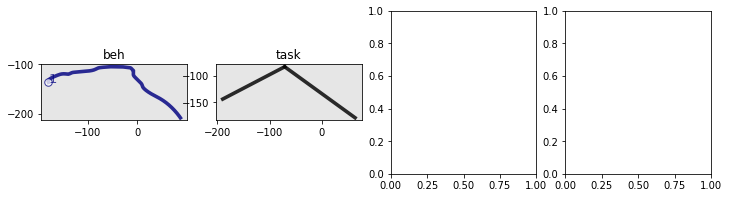

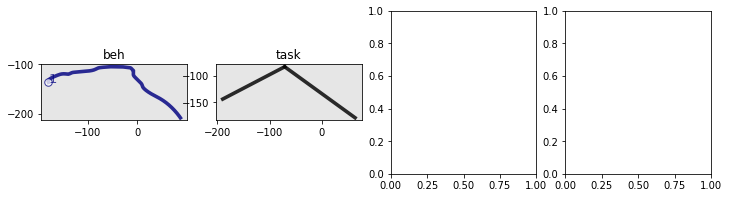

In [95]:
# view calculated length, angles for sample trial
sample_num = 500
print(D.Dat.iloc[sample_num]["task_len"])
print(D.Dat.iloc[sample_num]["task_rot_angle_rad"])
print(D.Dat.iloc[sample_num]["task_draw_angle_rad"])
D.plotSingleTrial(sample_num)

##### Bin tasks into categories

In [96]:
# test out new function: transform_data_to_negative_start()
#t = transform_data_to_negative_start([pi, 5*pi/4, 7*pi/4, 7*pi/4+0.05, 7*pi/4-0.0001, 2*pi], -pi/4)
#print(t)

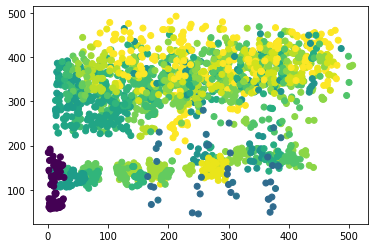

In [97]:
# visually determine length threshold for short, long lines
plt.scatter(D.Dat["trial"], D.Dat["task_len"], c=D.Dat["block"])

# looks like around 210
# lower bound: 0
# upper bound: 500

## NOTE: for naive8luca6: added separate maketasks.m functions for twolinesobtusenaturalXY, up, down
## - used shorter lengths for up, down (.15 to .23, vs .20 to .28)
## - rationale: was generating off-grid, sampling took forever, so shrunk

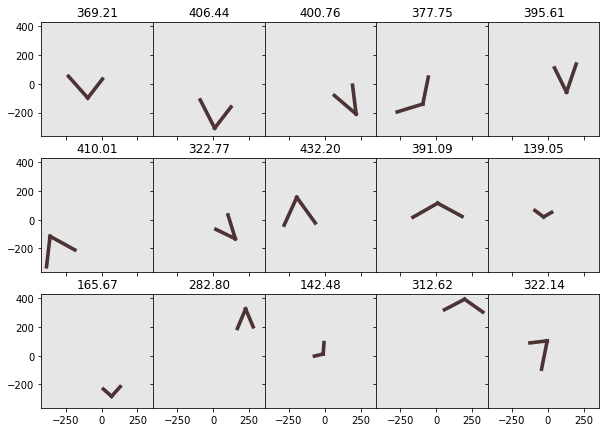

In [98]:
# plot a random sample of trials, to compare lengths (confirm above is correct)

import random
inds = random.sample(range(len(D.Dat)), 15)
lens = D.Dat.iloc[inds]["task_len"].tolist()
D.plotMultTrials(inds, which_strokes="strokes_task", titles=lens);

In [99]:
## BIN [drawing_angle, rotation_angle, length] data into categories
# - rotation_angle has 4 categories: [right, up, left, down]
# - drawing_angle has 2 categories: [acute, obtuse]
# - length has 2 categories: [short, long]
#
## THEN, create 1 category for each permutation across the 3 features (4x2x2 = 16)

# fake angle distribution
# test_angles = 2*pi*np.random.rand(100)

# step 1: negative transform of data (since pointing right encompasses angles [0 pi/4], [7pi/4 2pi])
D.Dat["task_rot_angle_negtform"] = transform_data_to_negative_start(D.Dat["task_rot_angle_rad"], -pi/4)
rot_angles_all = D.Dat["task_rot_angle_negtform"]

# step 2: categorize newly transformed angle data into [right, up, left, down]
rot_angles_binned = bin_angle_by_direction(rot_angles_all, -pi/4, 4, binnames={1: 'right', 2: 'up', 3: 'left', 4: 'down', 5: np.nan});
D.Dat["task_rot_angle_cat"] = rot_angles_binned
print(D.Dat["task_rot_angle_cat"].value_counts())

# step 3: categorize drawing angle data into [acute, obtuse]
draw_angles_all = D.Dat["task_draw_angle_rad"]
draw_angles_bins = [0, pi/2, pi] # tasks are defined between 2pi/8 and 7pi/8 (23,34,45,56,67)
D.Dat["task_draw_angle_cat"] = np.digitize(draw_angles_all, draw_angles_bins) # data is categorized as [1,2]
D.Dat["task_draw_angle_cat"] = D.Dat["task_draw_angle_cat"].astype('category') # retype
D.Dat["task_draw_angle_cat"] = D.Dat["task_draw_angle_cat"].cat.rename_categories({1: 'acute', 2: 'obtuse'}) # map labels to text
print(D.Dat["task_draw_angle_cat"].value_counts())

# step 4: categorize length data into [short, long]
lengths_all = D.Dat["task_len"]
lengths_bins = [0, 210, 500] # per above cell, data clusters into 0..210 and 210..500
D.Dat["task_len_cat"] = np.digitize(lengths_all, lengths_bins) # data is categorized as [1,2]
D.Dat["task_len_cat"] = D.Dat["task_len_cat"].astype('category') # retype
D.Dat["task_len_cat"] = D.Dat["task_len_cat"].cat.rename_categories({1: 'short', 2: 'long'}) # map labels to text
print(D.Dat["task_len_cat"].value_counts())

# step 5: create 1 category for each permutation across 3 features (4x2x2 = 16)
from pythonlib.tools.pandastools import append_col_with_grp_index

D.Dat = append_col_with_grp_index(D.Dat, ["task_len_cat", "task_rot_angle_cat", "task_draw_angle_cat"], "lenrotdraw_cat")

lenrotdraw_cat = D.Dat["lenrotdraw_cat"].unique()

#perms = perms.astype('category')
#perms.cat.codes.value_counts()
                                

down     961
up       782
right    255
left     146
Name: task_rot_angle_cat, dtype: int64
acute     1190
obtuse     954
Name: task_draw_angle_cat, dtype: int64
long     1565
short     579
Name: task_len_cat, dtype: int64


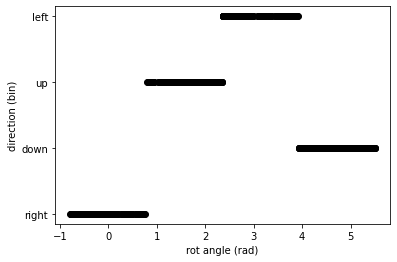

In [100]:
# Plot to see rotation angles, categorized
plt.figure()
plt.plot(rot_angles_all, rot_angles_binned, 'ok')
plt.xlabel('rot angle (rad)');
plt.ylabel('direction (bin)');

##### Now, for each task category plot (1) drawings (2) scores.

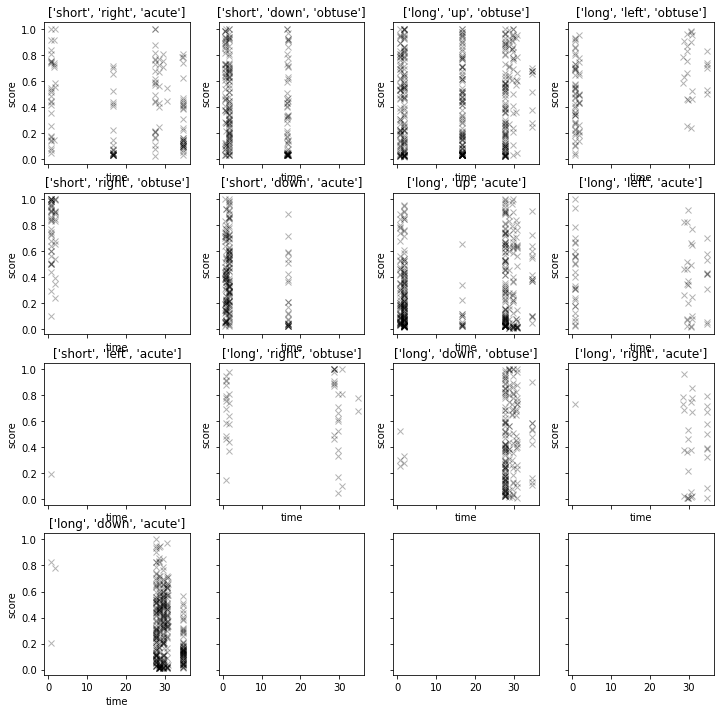

In [101]:
# make 16 plots: reward_score vs. time
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=[3*4,3*4])

for cat, ax in zip(lenrotdraw_cat, axes.flatten()):
    # get time, score
    cat_df = D.Dat.loc[D.Dat["lenrotdraw_cat"] == cat]
    cat_time = cat_df["tvalfake"]
    cat_score = cat_df["score_final"]
    # now make figure
    ax.plot(cat_time, cat_score, 'xk',alpha=0.3)
    ax.set_xlabel('time');
    ax.set_ylabel('score');
    ax.set_title(cat)
    
# plot means for each day, box-whiskers?
#
# comparison 1: pairwise (which ones is he better at)
# comparison 2: daywise (does he improve at the worse ones by day)

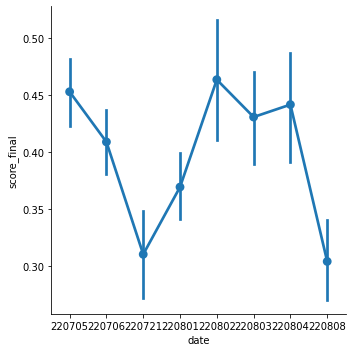

In [102]:
sns.catplot(x='date', y='score_final',
            data=D.Dat, alpha=0.2, kind='point')

# "performance over time"

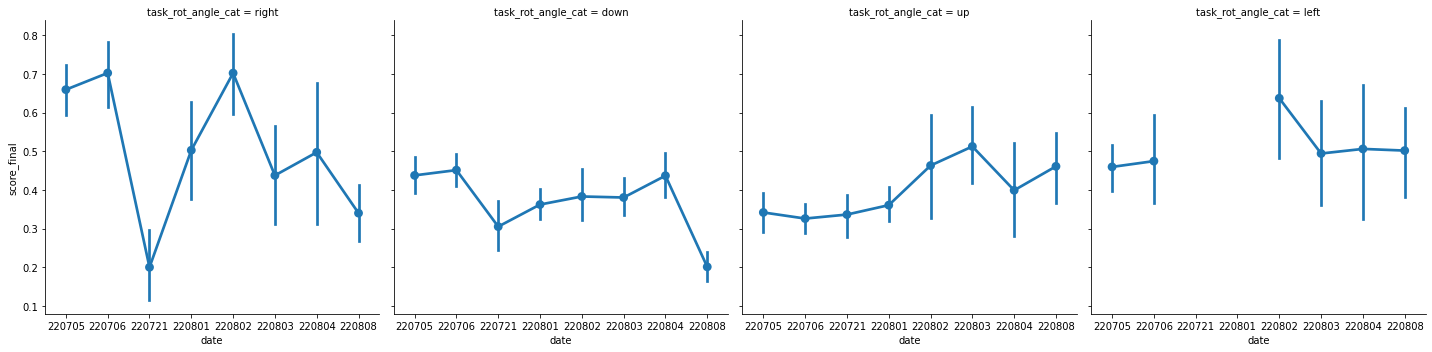

In [103]:
# timecourse for each direction (up/down/left/right)
sns.catplot(x='date', y='score_final',
            col='task_rot_angle_cat',
            data=D.Dat, alpha=0.2, kind='point')

# "performance over time in each direction"

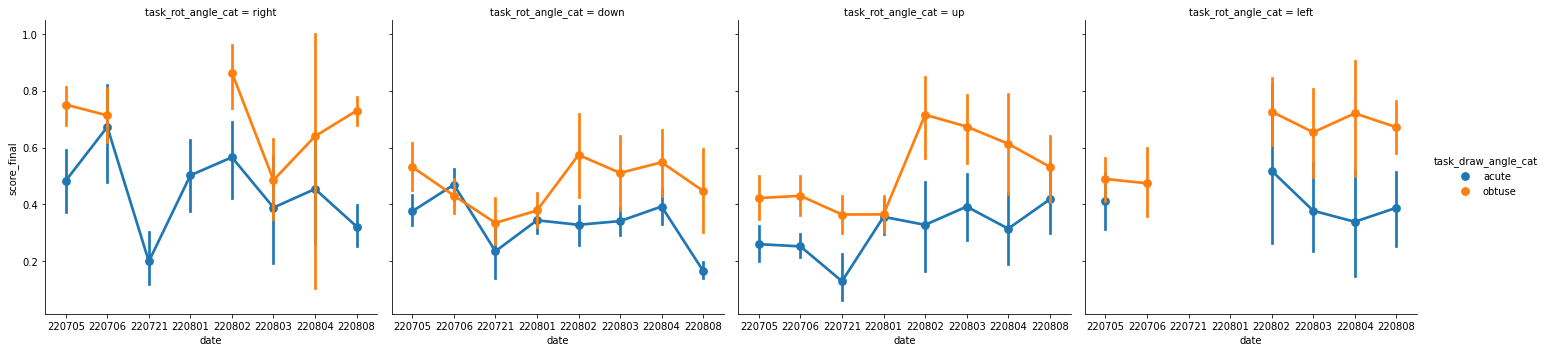

In [104]:
# timecourse for each direction (up/down/left/right)
sns.catplot(x='date', y='score_final',
            col='task_rot_angle_cat',
            hue='task_draw_angle_cat',
            data=D.Dat, alpha=0.2, kind='point')

# "performance over time in each direction; and further split by acute/obtuse"

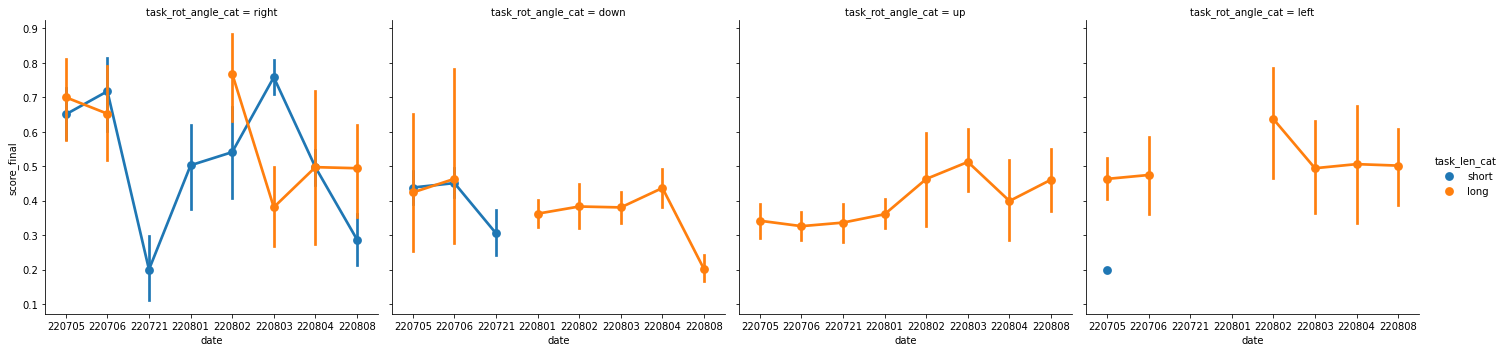

In [105]:
# timecourse for each length (short/long)
# NOTE: 3x as many long as short...
sns.catplot(x='date', y='score_final',
            col='task_rot_angle_cat',
            hue='task_len_cat',
            data=D.Dat, alpha=0.2, kind='point')

# "performance over time in each direction; and further split by length"

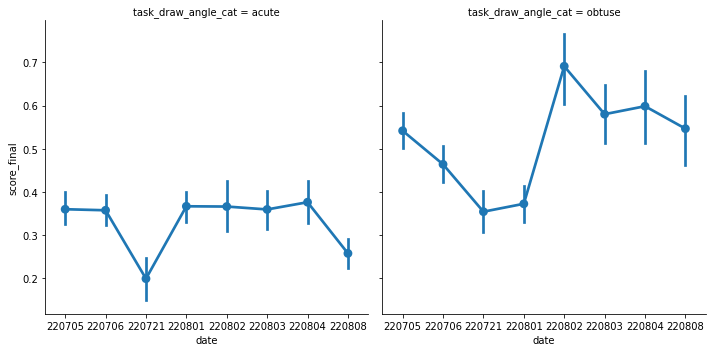

In [106]:
# timecourse for each drawing angle (acute/obtuse)
sns.catplot(x='date', y='score_final',
            col='task_draw_angle_cat',
            data=D.Dat, alpha=0.2, kind='point')

# "performance over time for acute/obtuse"

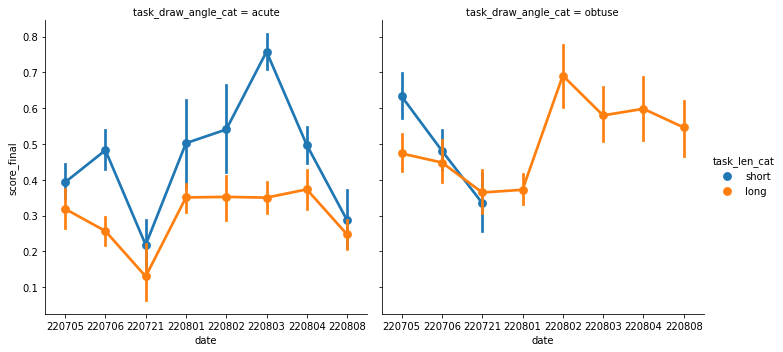

In [107]:
# timecourse for each drawing angle (acute/obtuse)
sns.catplot(x='date', y='score_final',
            col='task_draw_angle_cat',
            hue='task_len_cat',
            data=D.Dat, alpha=0.2, kind='point')

# "performance over time for acute/obtuse; and further split by length"